In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

In [4]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/DAV/labeled_data_final.csv')

In [5]:
# Chọn các cột FPED làm features
fped_cols = [c for c in df.columns if 'cup eq.' in c or 'oz. eq.' in c
             or 'grams' in c or 'tsp. eq.' in c or 'drinks' in c]

# Loại bỏ các cột 'TOTAL' để tránh multicollinearity
fped_cols = [c for c in fped_cols if 'TOTAL' not in c]

print(f"Số features được chọn: {len(fped_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(fped_cols, 1):
    print(f"  {i:2d}. {col}")

Số features được chọn: 29

Features:
   1. F_CITMLB (cup eq.)
   2. F_OTHER (cup eq.)
   3. F_JUICE (cup eq.)
   4. V_DRKGR (cup eq.)
   5. V_REDOR_TOMATO (cup eq.)
   6. V_REDOR_OTHER (cup eq.)
   7. V_STARCHY_POTATO (cup eq.)
   8. V_STARCHY_OTHER (cup eq.)
   9. V_OTHER (cup eq.)
  10. V_LEGUMES (cup eq.)
  11. G_WHOLE (oz. eq.)
  12. G_REFINED (oz. eq.)
  13. PF_MEAT (oz. eq.)
  14. PF_CUREDMEAT (oz. eq.)
  15. PF_ORGAN (oz. eq.)
  16. PF_POULT (oz. eq.)
  17. PF_SEAFD_HI (oz. eq.)
  18. PF_SEAFD_LOW (oz. eq.)
  19. PF_EGGS (oz. eq.)
  20. PF_SOY (oz. eq.)
  21. PF_NUTSDS (oz. eq.)
  22. PF_LEGUMES (oz. eq.)
  23. D_MILK (cup eq.)
  24. D_YOGURT (cup eq.)
  25. D_CHEESE (cup eq.)
  26. OILS (grams)
  27. SOLID_FATS (grams)
  28. ADD_SUGARS (tsp. eq.)
  29. A_DRINKS (no. of drinks)


In [6]:
# Chuẩn bị X và y
X = df[fped_cols]
y = df['Label_Value']  # 0=Bad, 1=Medium, 2=Good

# Chuẩn hóa features (Z-score)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=fped_cols, index=df.index)

print("Data prepared!")
print(f"   X shape: {X_scaled.shape}")
print(f"   y shape: {y.shape}")

Data prepared!
   X shape: (7080, 29)
   y shape: (7080,)


---
## 2. Feature Correlation Analysis

**Kỹ thuật**: Pearson Correlation & Spearman Correlation

**Mục đích**: Tìm hiểu mối quan hệ giữa các features

PEARSON CORRELATION ANALYSIS


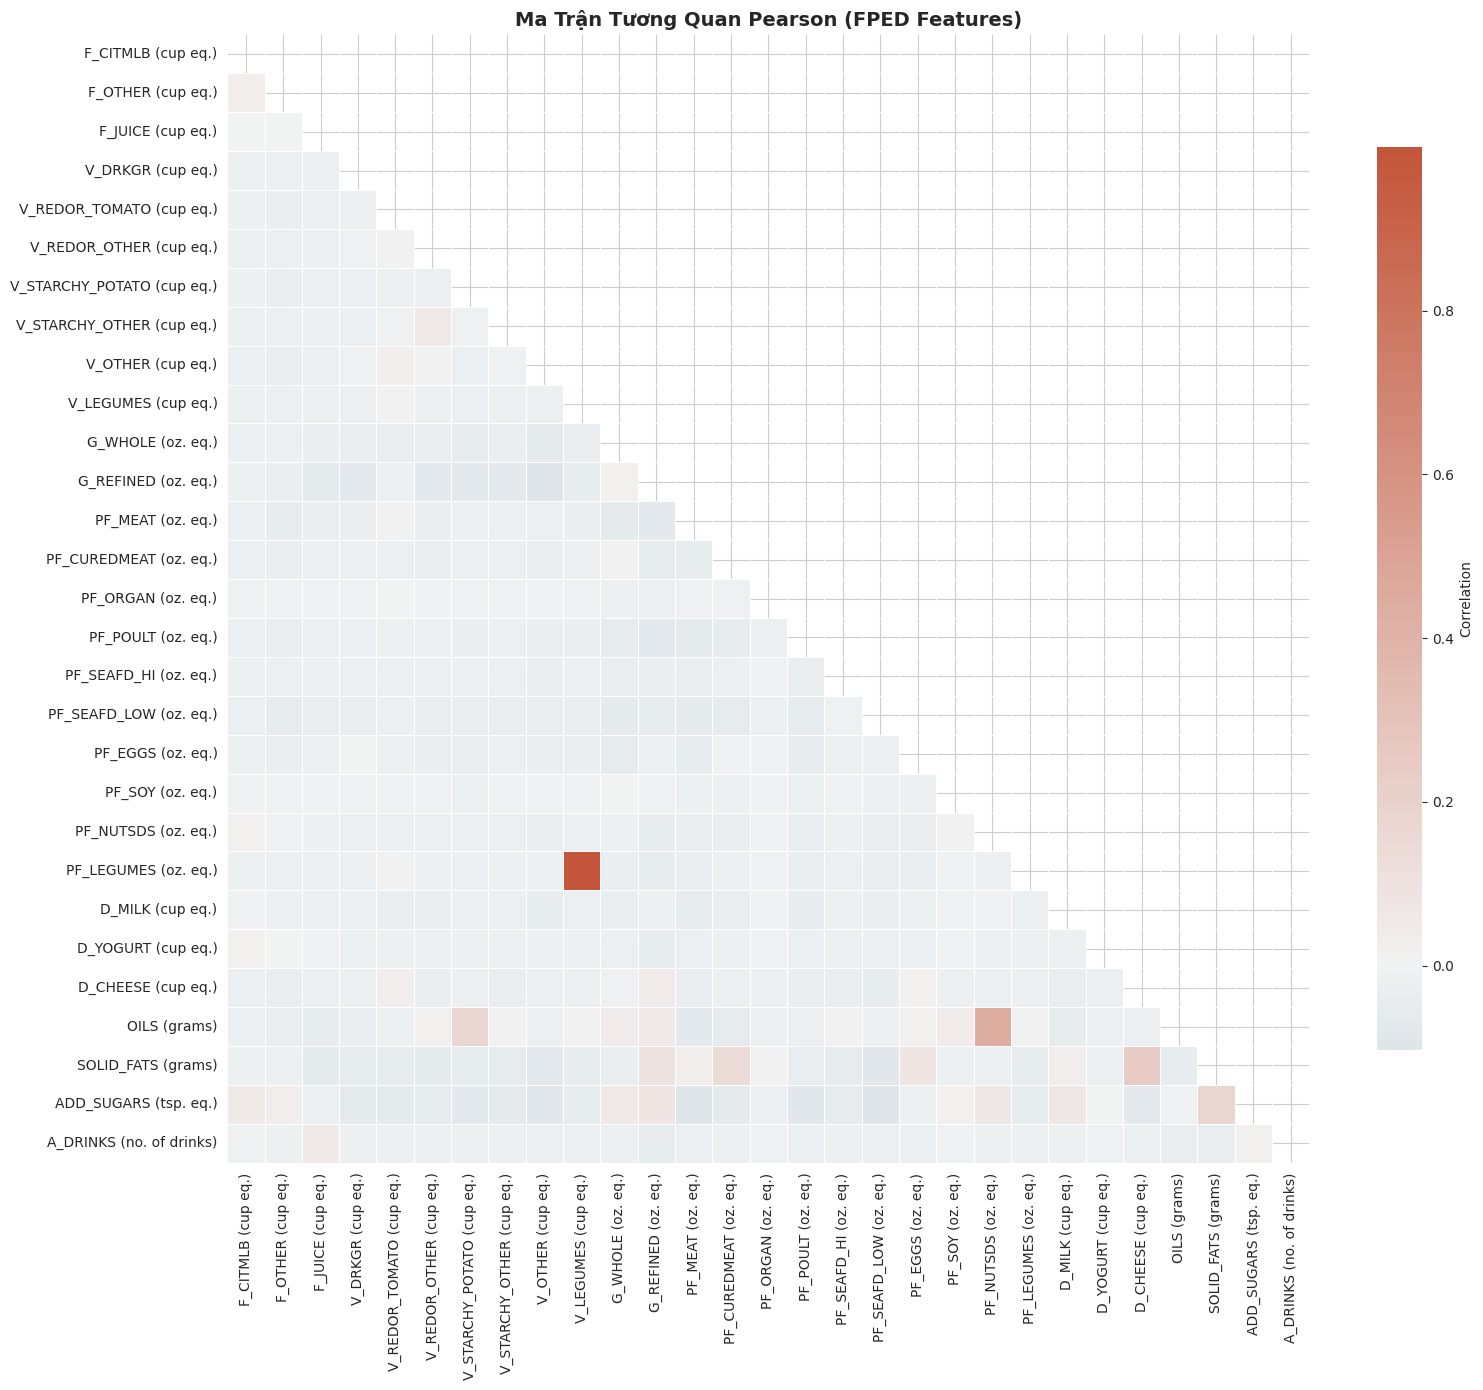

Đã lưu: pearson_heatmap.png


In [9]:
# 2.1 Pearson Correlation Matrix
print("=" * 60)
print("PEARSON CORRELATION ANALYSIS")
print("=" * 60)

pearson_corr = X_scaled.corr(method='pearson')

# Heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pearson_corr, mask=mask, cmap=cmap, center=0,
            annot=False, fmt='.2f', linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'})
plt.title('Ma Trận Tương Quan Pearson (FPED Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/pearson_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: pearson_heatmap.png")

In [10]:
# 2.2 Tìm các cặp có tương quan cao
def find_high_correlations(corr_matrix, threshold=0.7):
    """Tìm các cặp features có tương quan cao"""
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > threshold:
                high_corr_pairs.append({
                    'Feature 1': corr_matrix.columns[i],
                    'Feature 2': corr_matrix.columns[j],
                    'Pearson r': round(corr_val, 3)
                })
    return pd.DataFrame(high_corr_pairs)

print("\nCÁC CẶP FEATURES CÓ TƯƠNG QUAN CAO (|r| > 0.7)")
print("-" * 60)
high_corr = find_high_correlations(pearson_corr, 0.7)
if len(high_corr) > 0:
    print(high_corr.sort_values('Pearson r', ascending=False).to_string(index=False))
else:
    print("Không có cặp nào có |r| > 0.7")


CÁC CẶP FEATURES CÓ TƯƠNG QUAN CAO (|r| > 0.7)
------------------------------------------------------------
          Feature 1            Feature 2  Pearson r
V_LEGUMES (cup eq.) PF_LEGUMES (oz. eq.)        1.0



SPEARMAN CORRELATION ANALYSIS


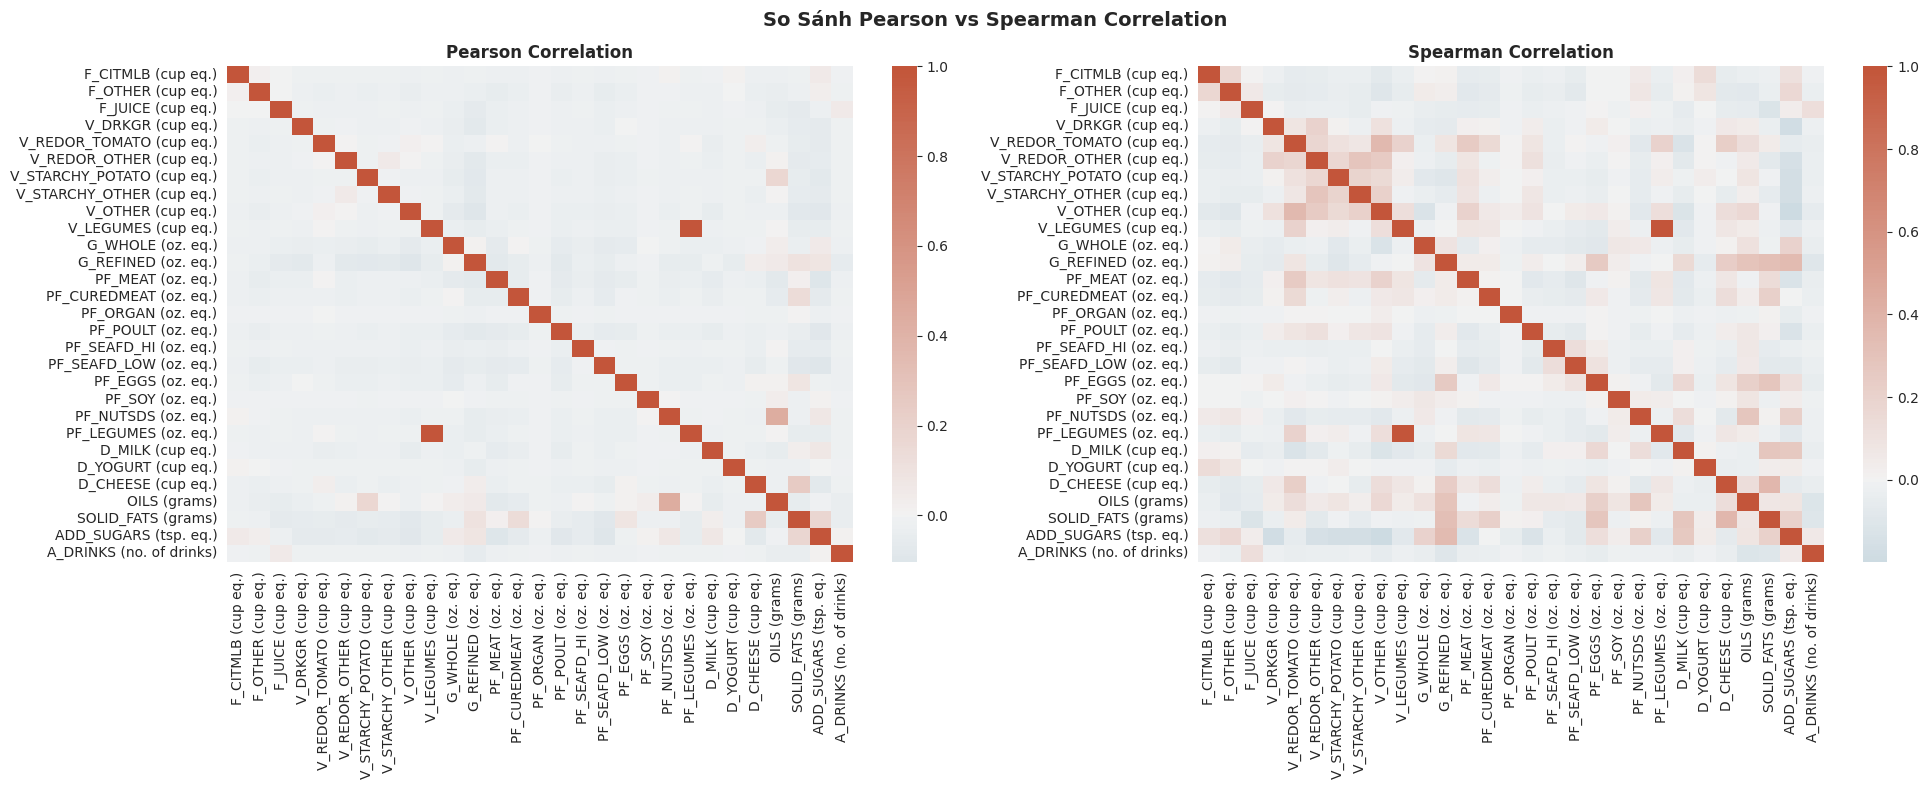

Đã lưu: correlation_comparison.png


In [11]:
# 2.3 Spearman Correlation
print("\n" + "=" * 60)
print("SPEARMAN CORRELATION ANALYSIS")
print("=" * 60)

spearman_corr = X_scaled.corr(method='spearman')

# So sánh Pearson vs Spearman
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pearson
sns.heatmap(pearson_corr, ax=axes[0], cmap=cmap, center=0, annot=False, cbar=True)
axes[0].set_title('Pearson Correlation', fontsize=12, fontweight='bold')

# Spearman
sns.heatmap(spearman_corr, ax=axes[1], cmap=cmap, center=0, annot=False, cbar=True)
axes[1].set_title('Spearman Correlation', fontsize=12, fontweight='bold')

plt.suptitle('So Sánh Pearson vs Spearman Correlation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/correlation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: correlation_comparison.png")

In [13]:
# 2.4 Phân tích sự khác biệt Pearson vs Spearman
diff_matrix = (pearson_corr - spearman_corr).abs()
print(f"\nPhân tích sự khác biệt Pearson vs Spearman:")
print(f"   • Độ chênh lệch trung bình: {diff_matrix.values.mean():.4f}")
print(f"   • Độ chênh lệch lớn nhất: {diff_matrix.values.max():.4f}")


Phân tích sự khác biệt Pearson vs Spearman:
   • Độ chênh lệch trung bình: 0.0484
   • Độ chênh lệch lớn nhất: 0.3435


---
## 3. PCA - Dimensionality Reduction

**Kỹ thuật**: Principal Component Analysis

**Mục đích**: Giảm chiều dữ liệu và visualization

In [14]:
# 3.1 Áp dụng PCA
print("=" * 60)
print("PCA - PRINCIPAL COMPONENT ANALYSIS")
print("=" * 60)

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Tính cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

print(f"\nKết quả PCA:")
print(f"   • Số components ban đầu: {len(fped_cols)}")
print(f"   • Components cần để giữ 80% variance: {np.argmax(cumulative_variance >= 0.80) + 1}")
print(f"   • Components cần để giữ 90% variance: {np.argmax(cumulative_variance >= 0.90) + 1}")
print(f"   • Components cần để giữ 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")

PCA - PRINCIPAL COMPONENT ANALYSIS

Kết quả PCA:
   • Số components ban đầu: 29
   • Components cần để giữ 80% variance: 21
   • Components cần để giữ 90% variance: 24
   • Components cần để giữ 95% variance: 25


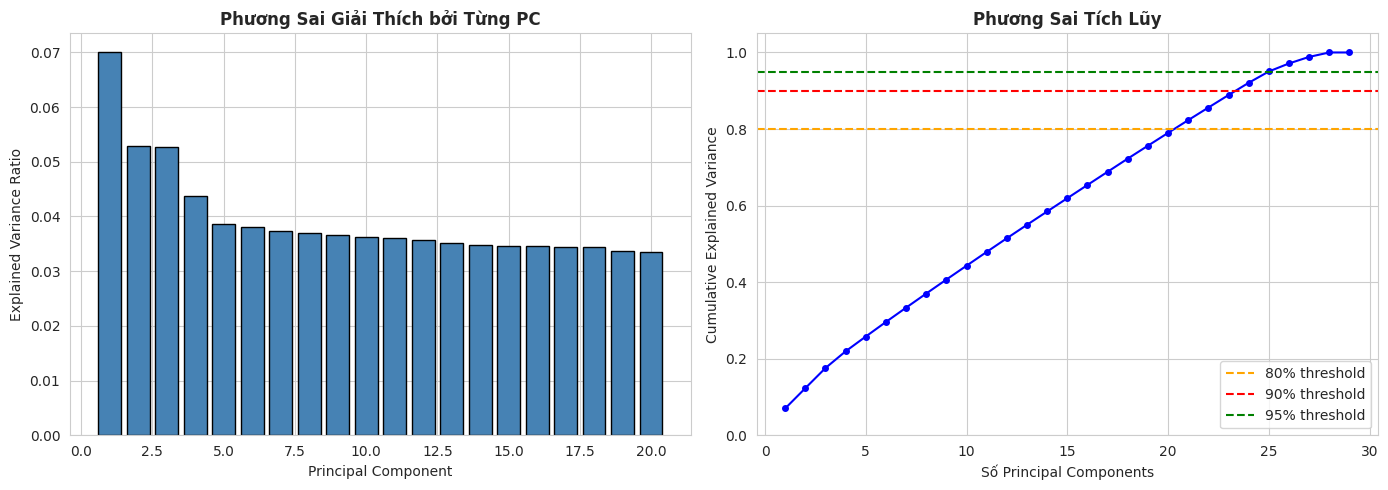

Đã lưu: pca_variance.png


In [16]:
# 3.2 Visualization: Explained Variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
n_show = min(20, len(pca_full.explained_variance_ratio_))
axes[0].bar(range(1, n_show+1), pca_full.explained_variance_ratio_[:n_show],
            color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Phương Sai Giải Thích bởi Từng PC', fontweight='bold')

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'bo-', markersize=4)
axes[1].axhline(y=0.80, color='orange', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.90, color='red', linestyle='--', label='90% threshold')
axes[1].axhline(y=0.95, color='green', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Số Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Phương Sai Tích Lũy', fontweight='bold')
axes[1].legend()
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DAV/pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: pca_variance.png")

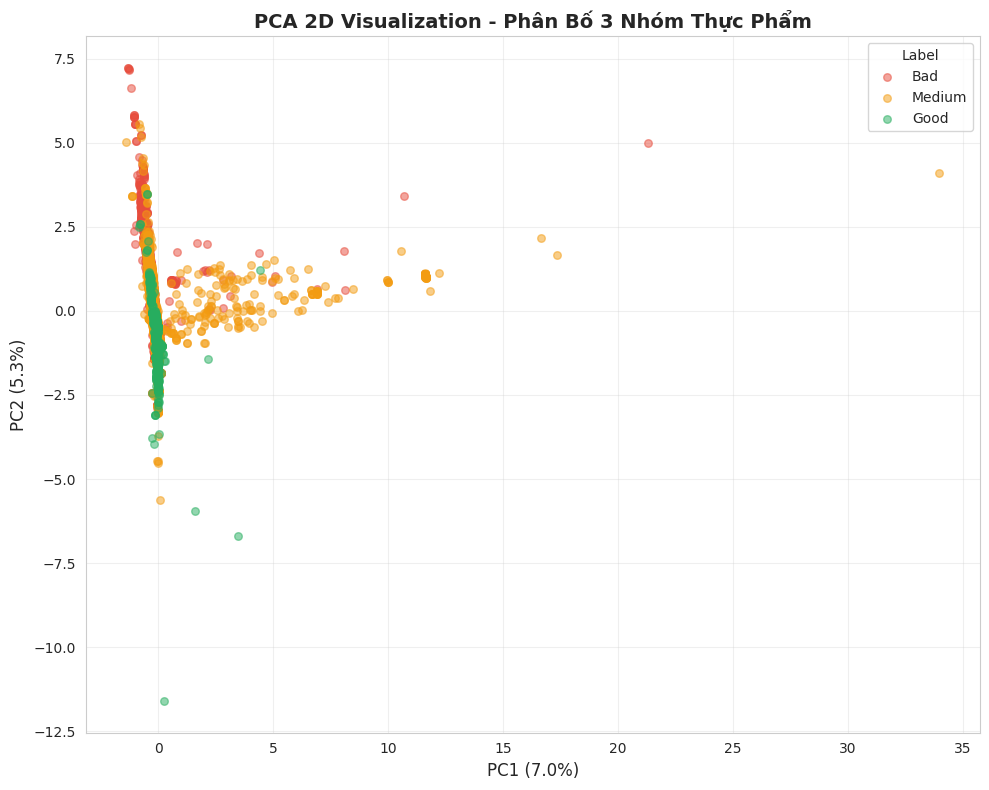

Đã lưu: pca_2d.png

PC1 + PC2 giải thích 12.3% tổng phương sai


In [18]:
# 3.3 PCA 2D Visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
colors = {0: '#e74c3c', 1: '#f39c12', 2: '#27ae60'}  # Bad=Red, Medium=Orange, Good=Green
labels = {0: 'Bad', 1: 'Medium', 2: 'Good'}

for label in [0, 1, 2]:
    mask = y == label
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
                c=colors[label], label=labels[label], alpha=0.5, s=30)

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=12)
plt.title('PCA 2D Visualization - Phân Bố 3 Nhóm Thực Phẩm', fontsize=14, fontweight='bold')
plt.legend(title='Label', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_2d.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: pca_2d.png")

print(f"\nPC1 + PC2 giải thích {pca_2d.explained_variance_ratio_.sum():.1%} tổng phương sai")

In [19]:
# 3.4 Top features đóng góp vào PC1 và PC2
pca_components = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=fped_cols
)
pca_components['PC1_abs'] = pca_components['PC1'].abs()

print("\nTop 10 Features đóng góp nhiều nhất vào PC1:")
print("-" * 50)
print(pca_components.sort_values('PC1_abs', ascending=False)[['PC1']].head(10).to_string())


Top 10 Features đóng góp nhiều nhất vào PC1:
--------------------------------------------------
                            PC1
PF_LEGUMES (oz. eq.)   0.696071
V_LEGUMES (cup eq.)    0.696070
SOLID_FATS (grams)    -0.090658
ADD_SUGARS (tsp. eq.) -0.086627
G_REFINED (oz. eq.)   -0.071226
PF_EGGS (oz. eq.)     -0.044834
G_WHOLE (oz. eq.)     -0.042987
D_MILK (cup eq.)      -0.035394
D_CHEESE (cup eq.)    -0.032306
F_OTHER (cup eq.)     -0.027710
